<a href="https://colab.research.google.com/github/Astra42/ImageComparison/blob/main/OverLiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Пока черновой вариант генератора чертежей по пнг-деталям 


In [8]:
import cv2
import numpy as np
import random as rm
from google.colab.patches import cv2_imshow
import string
import math
import os.path

In [9]:
class Point:
  def __init__(self, x,y):
    self.x, self.y = x, y
  def addForEach(self, x, y):
    self.x+=x
    self.y+=y

  def get(self):
    return self.x, self.y
  
  def __str__(self):
      return f"{self.x, self.y}"

In [10]:
class MainFrame:
  def __init__(self, corners):
    self.corners = corners
    self.shape = corners[3].y-corners[0].y, corners[1].x-corners[0].x
  
  def __str__(self):
      return [str(c) for c in self.corners]

In [11]:
def findBorder(img):
  midy,midx = img.shape[0]//2, img.shape[1]//2
  points = [Point(midx, midy) for _ in range(4)]
  top=0
  
  while(img[points[0].y,points[0].x][0] > 200):
    points[0].y-=1
    top+=1

  left=0
  while(img[points[3].y,points[3].x][0] > 200):
    points[3].x-=1
    left+=1

  bottom,right=0,0
  while(img[points[1].y,points[1].x][0] > 200):
    points[1].x+=1
    right+=1

  points[2] = Point(points[1].x-5, points[1].y)
  while(img[points[2].y,points[2].x][0] > 200):
    points[2].y+=1
    bottom+=1

  corners = [Point(points[3].x, points[0].y),
             Point(points[1].x, points[0].y), 
             Point(points[1].x, points[2].y),
             Point(points[3].x, points[2].y),]
  
  mf = MainFrame(corners)

  return mf

In [186]:
# img1 = np.zeros((500,500,3), dtype="uint8")
img1 = cv2.imread('/content/backend.jpg')
img2 = cv2.imread('/content/1.png')

scale_percent = 16 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)

img1 = cv2.resize(img1, dim)
img1.shape


(1122, 794, 3)

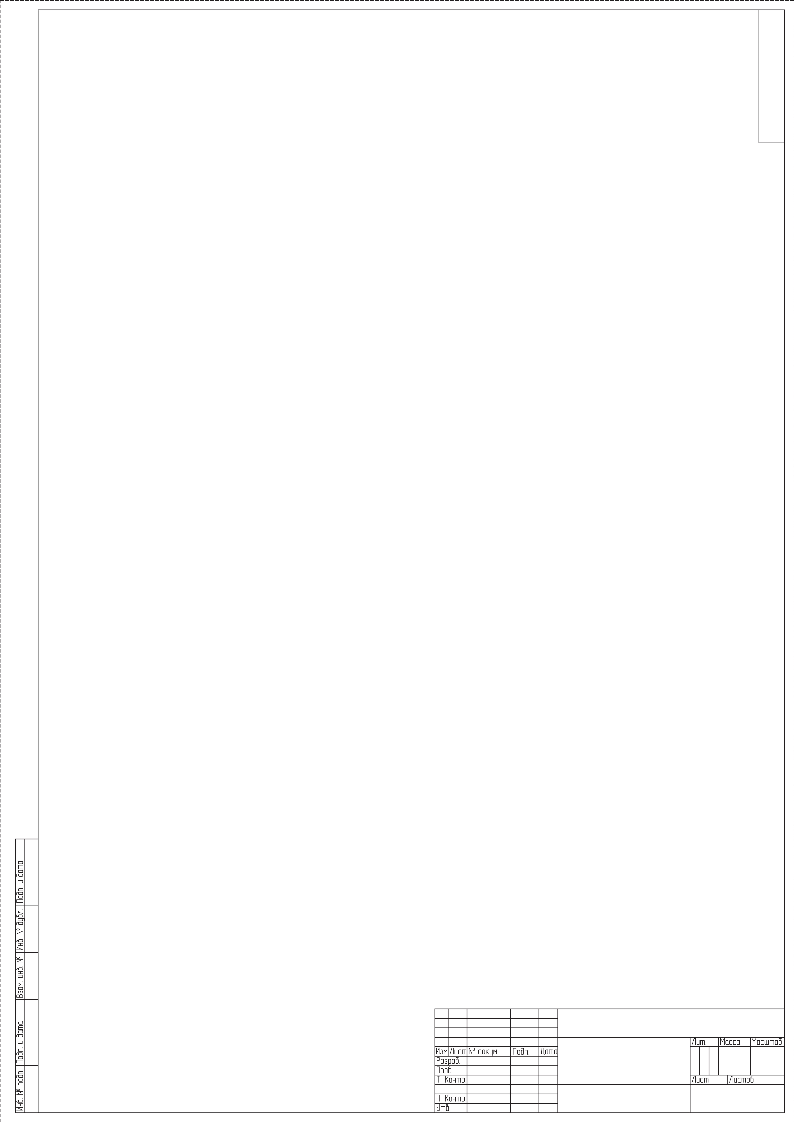

In [187]:
cv2_imshow(img1)

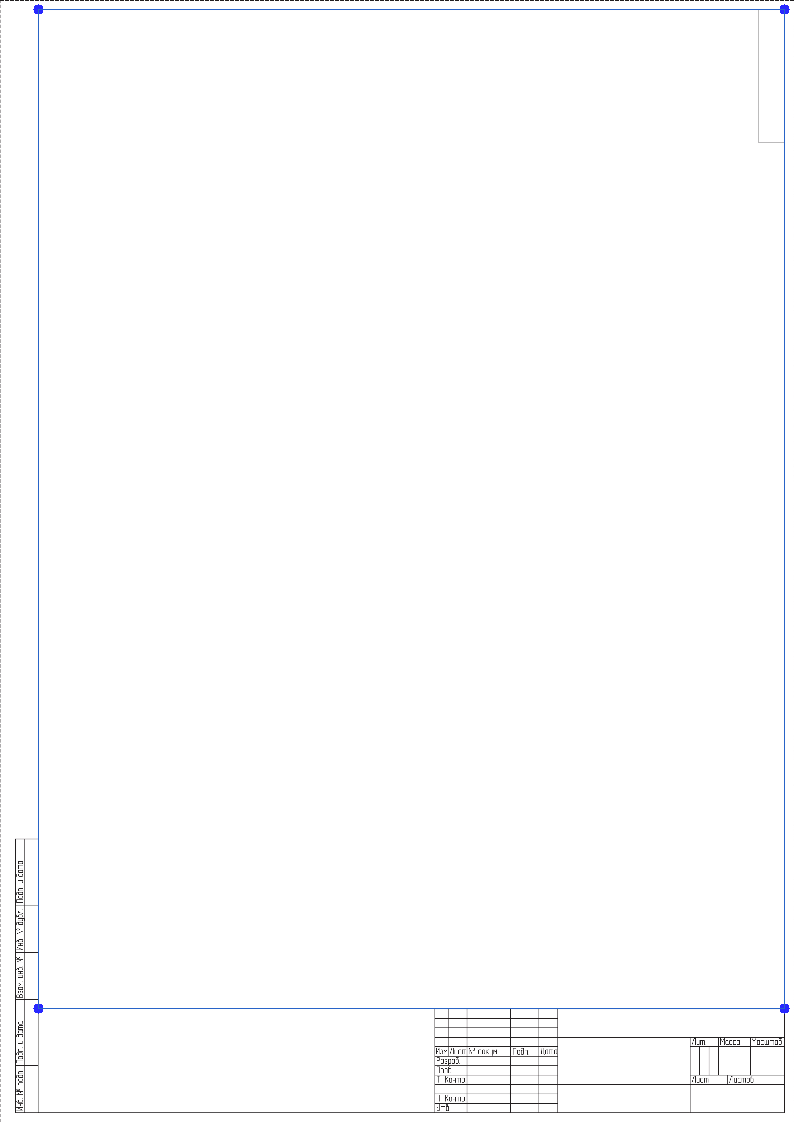

In [188]:
mf = findBorder(img1)

for i in mf.corners:
  cv2.circle(img1, i.get(), 5, (255, 40, 40), cv2.FILLED)

cv2.rectangle(img1, (mf.corners[0].x, mf.corners[0].y) , (mf.corners[2].x, mf.corners[2].y), (200, 100, 40))

cv2_imshow(img1)

In [168]:
mf.shape

(999, 746)

In [189]:
#Base
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
class Polygon:
  def __init__(self, xy, shape):
    self.xy = xy
    self.x = xy[0]
    self.y = xy[1]
    self.shape = shape
    self.w = shape[0]
    self.h = shape[1]
    self.square = self.w*self.h


class Polygon_finder:
  def __init__(self):
    self.figures = {"r": self.find_for_rectangle, "c":self.find_for_circle, "r_p": self.find_for_circle, 'cmpnt': self.find_for_rectangle}

  def find_for_rectangle(self, polygons,caller,n, min_square=500*5):
    polygon_index = rm.choice(range(len(polygons)))
    polygon = polygons.pop(polygon_index)
    while polygon.square<min_square:
      l = len(polygons)
      if l==0:
        print("Все, места нет")
        return 0
      else:
        polygon_index = rm.choice(range(l))
        polygon = polygons.pop(polygon_index)
    
    return polygon

  def find_for_circle(self, polygons, caller,n, min_square=500):
    polygon_index = rm.choice(range(len(polygons)))
    polygon = polygons.pop(polygon_index)
    min_r = np.floor((min_square/np.pi)**(1/2)) if caller=="c" else np.floor((2*min_square/n/np.sin(2*np.pi/n))**(1/2))
    while polygon.w<2*min_r or polygon.h<2*min_r:
      l = len(polygons)
      if l==0:
        print("Все, места нет")
        return 0
      else:
        polygon_index = rm.choice(range(l))
        polygon = polygons.pop(polygon_index)

    #print("полигон", polygon.shape)
    return polygon


  def init_search(self, polygons, figure, n):
    return self.figures[figure](polygons, figure, n)



def random_color(a=0, b=240):
  return (rm.randint(a, b), rm.randint(a, b), rm.randint(a, b))

def random_point(img_shape):
  return (rm.randint(0,img_shape[0]), rm.randint(0,img_shape[1]))

def floor(x):
  return math.floor(x)

def ceil(x):
  return math.ceil(x)


#Saver
#----------------------------------------------------------------------------------------------------------------------------------------------------------
def save_images(images, folder_name="media"):
  f_name = f"/{folder_name}/count_of_same_sample.txt"
  if not os.path.exists(f_name):
    open(f_name, 'w').write("0")
  
  count_of_same_images = int(open(f_name, 'r').read(1))

  for i in range(len(images)):
    cv2.imwrite(f"/{folder_name}/sample{count_of_same_images}_{i}.jpg", images[i])
  
  open(f_name, 'w').write(str(count_of_same_images+1))


#Figures
#---------------------------------------------------------------------------------------------------------------------------------------------------
class Rectangle:
  def __init__(self, polygon, min_square, color ,thickness=cv2.FILLED, padding=0.05):
    max_x =np.floor(polygon.w - min_square/polygon.h)
    x = rm.randint(0, max_x)
    max_y = np.floor(polygon.h - min_square/(polygon.w-x))
    y = rm.randint(0, max_y)
    p = (x,y)
    min_w = np.ceil(min_square/(polygon.h - y))
    w = rm.randint(min_w, polygon.w-p[0])
    min_h = np.ceil(min_square/w)
    h = rm.randint(min_h, polygon.h-p[1])
    self.shape = (w,h)
    #print(self.shape[0]*self.shape[1])
    self.start_point = (p[0]+polygon.x, p[1]+polygon.y)
    self.end_point = (self.shape[0] + self.start_point[0], self.shape[1] + self.start_point[1])
    self.color = color
    self.thickness=thickness

    self.outside_min_polygon = Polygon(self.start_point, self.shape)
    self.polygon_inside = Polygon((round(self.start_point[0] + self.shape[0]*padding), round(self.start_point[1] + self.shape[1]*padding)),
                                  (round(self.shape[0]*(1-2*padding)), round(self.shape[1]*(1-2*padding))))
    
def draw_rectangle(img, polygon, min_square, color):
  r = Rectangle(polygon, min_square, color)
  cv2.rectangle(img, r.start_point, r.end_point, r.color)
  return r


class Component:
  def __init__(self, polygon, min_square):
    max_x =np.floor(polygon.w - min_square/polygon.h)
    x = rm.randint(0, max_x)
    max_y = np.floor(polygon.h - min_square/(polygon.w-x))
    y = rm.randint(0, max_y)
    p = (x,y)
    min_w = np.ceil(min_square/(polygon.h - y))
    w = rm.randint(min_w, polygon.w-p[0])
    min_h = np.ceil(min_square/w)
    h = rm.randint(min_h, polygon.h-p[1])
    self.shape = (w,h)


    print(polygon.shape)
    print(p)
    print(max_x, max_y)
    print(min_w, min_h)
    print(w, h)
    print(self.shape)
    #print(self.shape[0]*self.shape[1])
    self.component = cv2.resize(cv2.imread(f'/content/{rm.randint(1, 10)}.png'), (w, h))
    for i in range(h):
      for j in range(w):
        self.component[i,j,:]= self.component[i,j,:] if self.component[i,j][0]!=0 else [255,255,255]
        
    self.start_point = (p[0]+polygon.x, p[1]+polygon.y)
    self.end_point = (self.shape[0] + self.start_point[0], self.shape[1] + self.start_point[1])
  
    self.outside_min_polygon = Polygon(self.start_point, self.shape)

def overlay(background, img, x, y):
  print('er', background.shape, img.shape, x, y)
  background[y:y+img.shape[0], x:x+img.shape[1],:]= img[:,:,:]
  return background
    
  


def draw_component(img, polygon, min_square, color):
  c = Component(polygon, min_square)
  print(img.shape, c.component.shape, c.start_point)
  overlay(img, c.component, c.start_point[0], c.start_point[1])
  cv2.circle(img, c.start_point, 3, (255, 40, 40), cv2.FILLED)
  return c




class Circle:
  def __init__(self, polygon, min_square, color, thickness=cv2.FILLED):
    min_r = np.floor((min_square/np.pi)**(1/2))
    c = (rm.randint(min_r, polygon.w-min_r), rm.randint(min_r, polygon.h-min_r))
    self.center = (c[0]+polygon.x, c[1]+polygon.y)
    self.r = rm.randint(min_r, 
                        min(c[0], c[1], polygon.w - c[0], polygon.h - c[1]))
    
    self.color = color
    self.thickness=thickness

    self.outside_min_polygon = Polygon((self.center[0]-self.r, self.center[1]-self.r), (2*self.r, 2*self.r))
    self.polygon_inside = Polygon((round(self.center[0] - 0.7071 * self.r), round(self.center[1]-0.7071 * self.r)), 
                                  (round(1.4142*self.r), round(1.4142*self.r)))
    

def draw_circle(img, polygon, min_square, color):
  c = Circle(polygon, min_square, color)
  cv2.circle(img, c.center, c.r, c.color, c.thickness)
  return c


#правильный многоугольник
class Regular_polygon:
  def __init__(self, polygon, n, min_square, color, thickness=1):
    min_r = np.floor((2*min_square/n/np.sin(2*np.pi/n))**(1/2))
    #print(min_r)
    c = (rm.randint(min_r, polygon.w-min_r), rm.randint(min_r, polygon.h-min_r))
    self.center = (c[0]+polygon.x, c[1]+polygon.y)
    self.r = rm.randint(min_r, 
                        min(c[0], c[1], polygon.w - c[0], polygon.h - c[1]))
    
    alphas = np.arange(0, 2*np.pi, 2*np.pi/n) + 2*np.pi*rm.random()
    self.points = [[self.center[0] +self.r*np.cos(a) , self.center[1] + self.r*np.sin(a)] for a in alphas]

    self.color = color
    self.thickness=thickness

    min_x = ceil(min(self.points, key=lambda x: x[0])[0])
    max_x = floor(max(self.points, key=lambda x: x[0])[0])
    min_y = ceil(min(self.points, key=lambda x: x[1])[1])
    max_y = floor(max(self.points, key=lambda x: x[1])[1])

    self.outside_min_polygon = Polygon((min_x, min_y), (max_x-min_x, max_y-min_y))

   
    self.polygon_inside = Polygon((round(self.center[0] - 0.3535 * self.r), round(self.center[1]-0.3535 * self.r)), 
                                 (round(0.7071*self.r), round(0.7071*self.r)))
    # не лучший полигон, пересечение с другими возможно, но так малО, что кажется касанием. Но он побольше
    #self.polygon_inside = Polygon((round(self.center[0] - 0.5 * self.r), round(self.center[1]-0.5 * self.r)), 
     #                             (round(self.r), round(self.r)))


def draw_regular_polygon(img, polygon, n, min_square, color):
  r_p = Regular_polygon(polygon, n, min_square, color)
  cv2.fillPoly(img, [np.array(r_p.points, 'int32')], color)
  return r_p
    

#Methods and Class Union
#-----------------------------------------------------------------------------------------------------------------------------------
class Plot:
  def __init__(self, img):
    self.img = img
    self.possible_polygons = [Polygon((0,0), img.shape[:2])]
    self.figures_in_plot = []
    self.possible_figures_draw_methods = {"r": draw_rectangle, "c": draw_circle, "r_p": draw_regular_polygon, 'cmpnt':draw_component}

  def draw_figure(self, figure_name, min_figure_square, regular=0):
    finder = Polygon_finder()
    polygon = finder.init_search(self.possible_polygons, figure_name, regular)

    if type(polygon)==type(1):
      return False

    #print(polygon.square)
    if not regular:
      figure = self.possible_figures_draw_methods[figure_name](self.img, polygon, min_figure_square, color=random_color())
      self.figures_in_plot.append(figure)
    else:
      figure = self.possible_figures_draw_methods[figure_name](self.img, polygon, regular, min_figure_square, color=random_color())
      self.figures_in_plot.append(figure)

    outside = figure.outside_min_polygon
    #print(outside.xy, outside.shape)
    first_p = Polygon((polygon.x, polygon.y), (outside.x-polygon.x + outside.w, outside.y-polygon.y))
    second_p = Polygon((polygon.x + first_p.w, polygon.y), (polygon.w-first_p.w, outside.y-polygon.y+outside.h))
    third_p = Polygon((outside.x, outside.y+outside.h), (polygon.w-outside.x+polygon.x, polygon.h-second_p.h))
    fourth_p = Polygon((polygon.x, polygon.y+first_p.h), (polygon.w-third_p.w, polygon.h-first_p.h))
    new_polygons = [first_p, second_p, third_p, fourth_p]
    #new_polygons = filter(lambda x: x.square>=min_figure_square, new_polygons)
    for p in new_polygons:
      self.possible_polygons.append(p)

    return True


def make_image(img_shape, comand, dict_of_k={"r":0.01, "c":0.002, "r_p":0.002, "cmpnt":0.002}):
  img_s = img_shape[0]*img_shape[1]
  dict_of_min_squares = {}
  for k in dict_of_k:
    dict_of_min_squares[k]=round(img_s * dict_of_k[k])

  comands = [v.split(":") for v in comand.split()]
  img = np.empty(img_shape)
  img.fill(255)
  plot = Plot(img)

  count=0
  for comand in comands:
    flag = False
    n = 0 if len(comand)==2 else int(comand[2])
    for i in range(int(comand[1])):
      figure = comand[0]
      can_continue = plot.draw_figure(figure, dict_of_min_squares[figure], n)

      if can_continue:
        count+=1
      else:
        print(f"Удалось построить {count} фигур")
        flag == True
        break
    
    if flag:
      break

  cv2_imshow(img)
  return img


def make_random_images(img_shape, count, percent, dict_of_k={"r":0.01, "c":0.002, "r_p":0.002}):
  img_s = img_shape[0]*img_shape[1]
  dict_of_min_squares = {}
  for k in dict_of_k:
    dict_of_min_squares[k]=round(img_s * dict_of_k[k])

  figures = ["r", "c", "r_p"]
  
  img = np.empty(img_shape)
  img.fill(255)

  plot = Plot(img)

  res = []
  c = 0
  for i in range(count):
    figure = rm.choice(figures)
    n = 0 if figure!="r_p" else rm.randint(3, 10)

    can_continue = plot.draw_figure(figure, dict_of_min_squares[figure], n)

    if can_continue:
      c+=1

    if c/count>=percent and len(res)==0:
      res.append(plot.img.copy())
    
    if not can_continue:
      print(f"Удалось построить {c} фигур для 1го изображения")
      res.append(plot.img)
      break

  res.append(plot.img)

  return res


(188, 61)
(126, 22)
163.0 36.0
39.0 29.0
52 35
(52, 35)
(999, 746, 3) (35, 52, 3) (126, 22)
er (999, 746, 3) (35, 52, 3) 126 22
(178, 22)
(93, 2)
110.0 4.0
75.0 18.0
83 20
(83, 20)
(999, 746, 3) (20, 83, 3) (93, 2)
er (999, 746, 3) (20, 83, 3) 93 2
(126, 39)
(75, 6)
87.0 9.0
46.0 32.0
48 32
(48, 32)
(999, 746, 3) (32, 48, 3) (75, 28)
er (999, 746, 3) (32, 48, 3) 75 28
(328, 127)
(55, 21)
316.0 121.0
15.0 6.0
273 21
(273, 21)
(999, 746, 3) (21, 273, 3) (55, 460)
er (999, 746, 3) (21, 273, 3) 55 460
(597, 95)
(115, 63)
581.0 91.0
47.0 8.0
210 29
(210, 29)
(999, 746, 3) (29, 210, 3) (517, 714)
er (999, 746, 3) (29, 210, 3) 517 714
(325, 63)
(122, 36)
301.0 55.0
56.0 19.0
82 19
(82, 19)
(999, 746, 3) (19, 82, 3) (524, 687)
er (999, 746, 3) (19, 82, 3) 524 687
(273, 85)
(50, 2)
255.0 78.0
18.0 35.0
43 80
(43, 80)
(999, 746, 3) (80, 43, 3) (105, 483)
er (999, 746, 3) (80, 43, 3) 105 483
(55, 106)
(24, 21)
40.0 57.0
18.0 56.0
27 69
(27, 69)
(999, 746, 3) (69, 27, 3) (24, 481)
er (999, 746, 3)

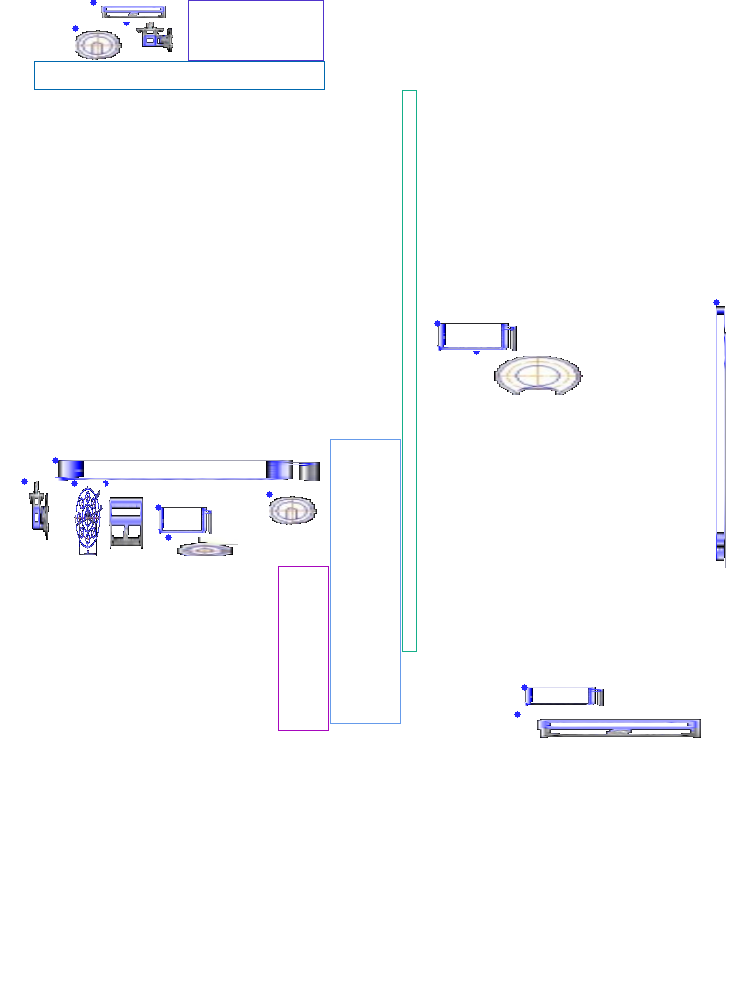

In [322]:
p = make_image((mf.shape[0], mf.shape[1], 3), "r:5 cmpnt:15")

In [233]:
p.shape

(999, 746, 3)

In [146]:
img1.shape

(1122, 794, 3)

In [110]:
mf.corners[0].x, mf.corners[0].y

(240, 64)

In [117]:
mf.shape

(6243, 4661)

er (1122, 794, 3) (999, 746, 3) 9 38


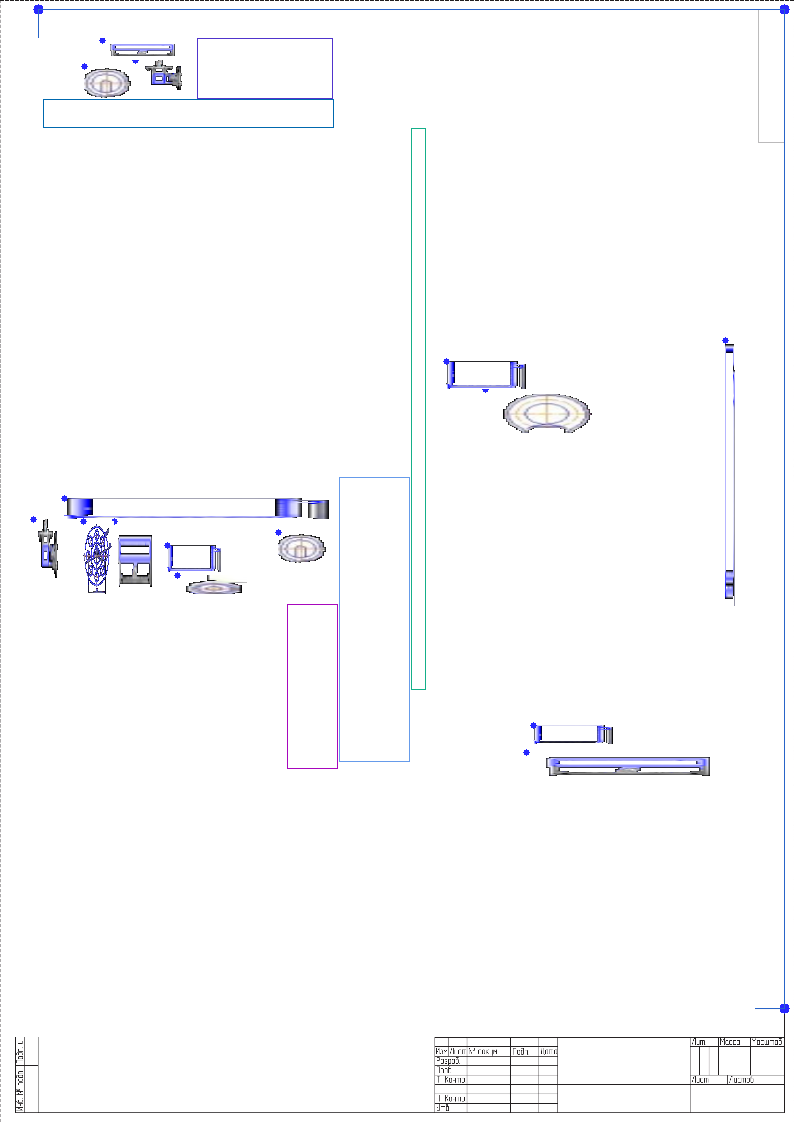

In [323]:
cv2_imshow(overlay(img1, p, mf.corners[0].y, mf.corners[0].x))

er (1122, 794, 3) (999, 746, 3) 9 38


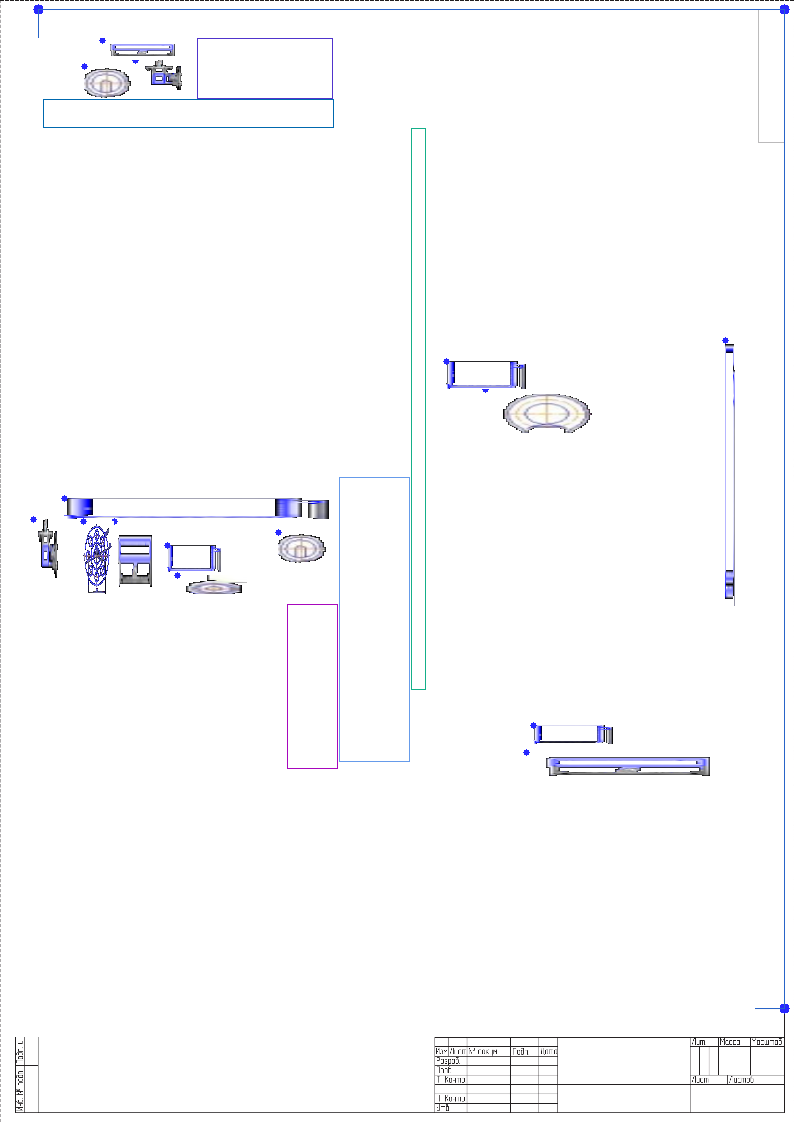

In [324]:
cv2_imshow(overlay(img1, p, mf.corners[0].y, mf.corners[0].x))

In [83]:
a = np.empty((4, 3, 2))
a.fill(255)
a

array([[[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]],

       [[255., 255.],
        [255., 255.],
        [255., 255.]]])

In [ ]:
img1.shape

(7017, 4963, 3)

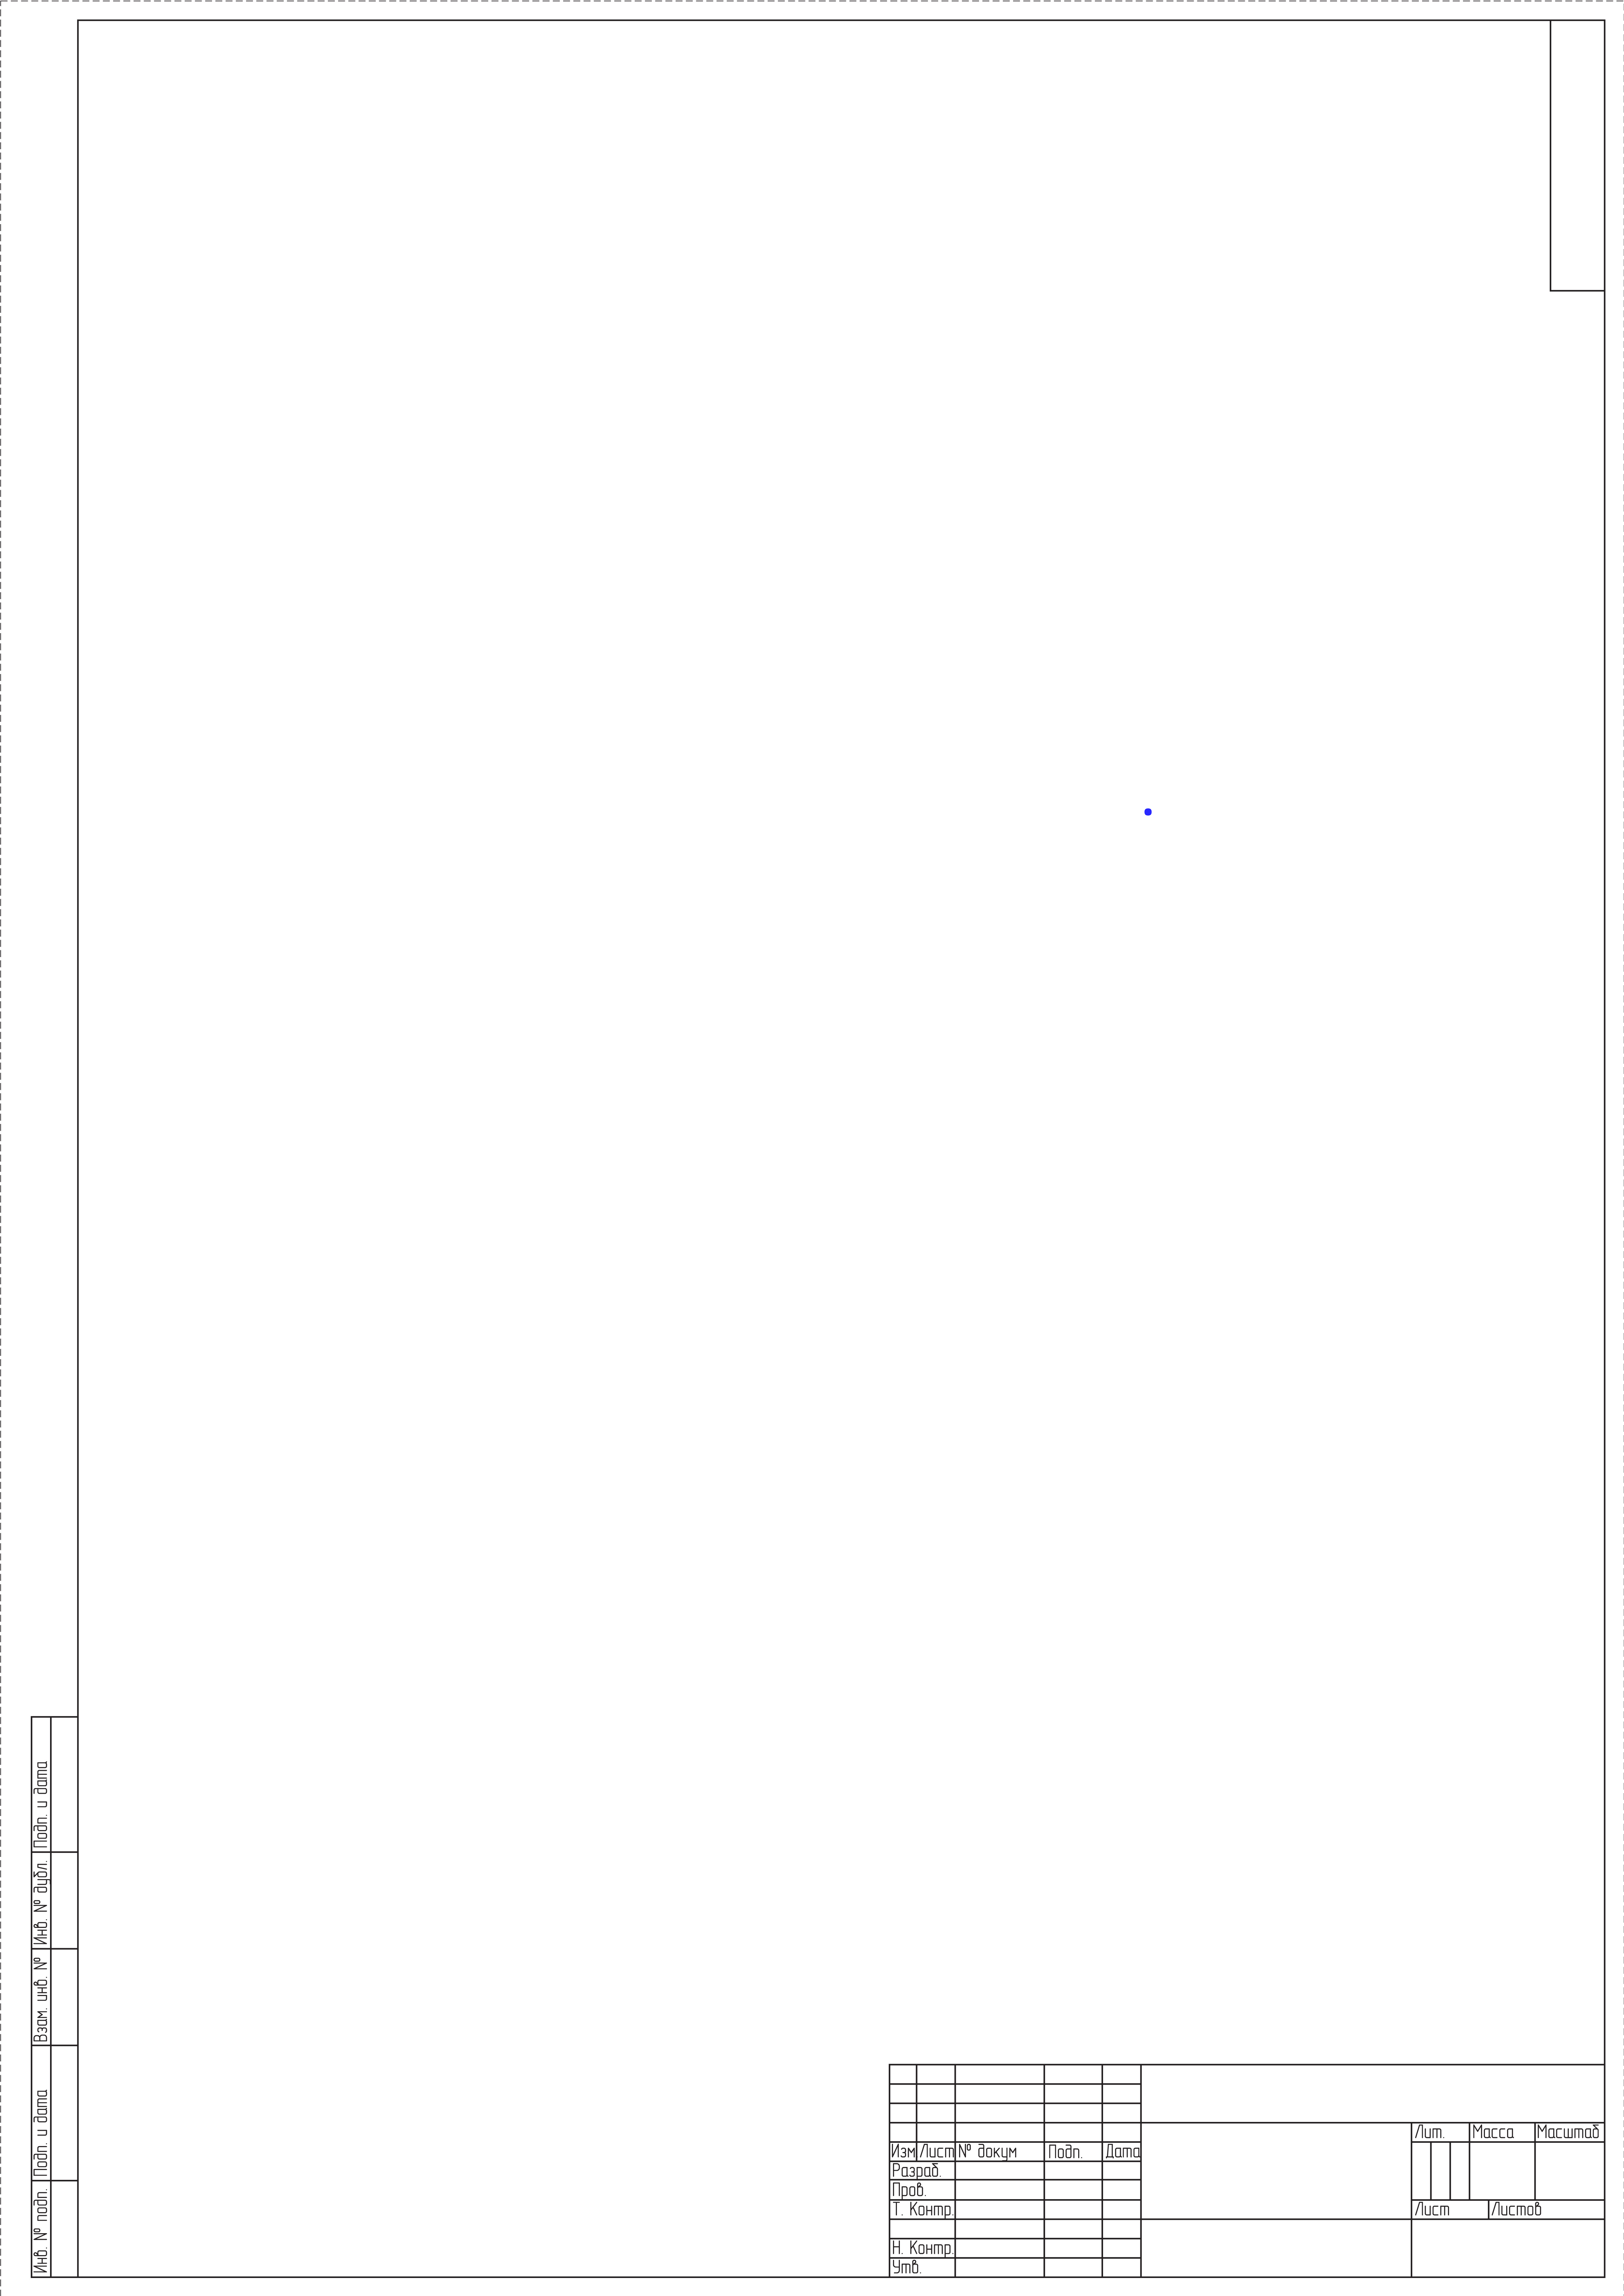

In [ ]:
cv2_imshow(img1)

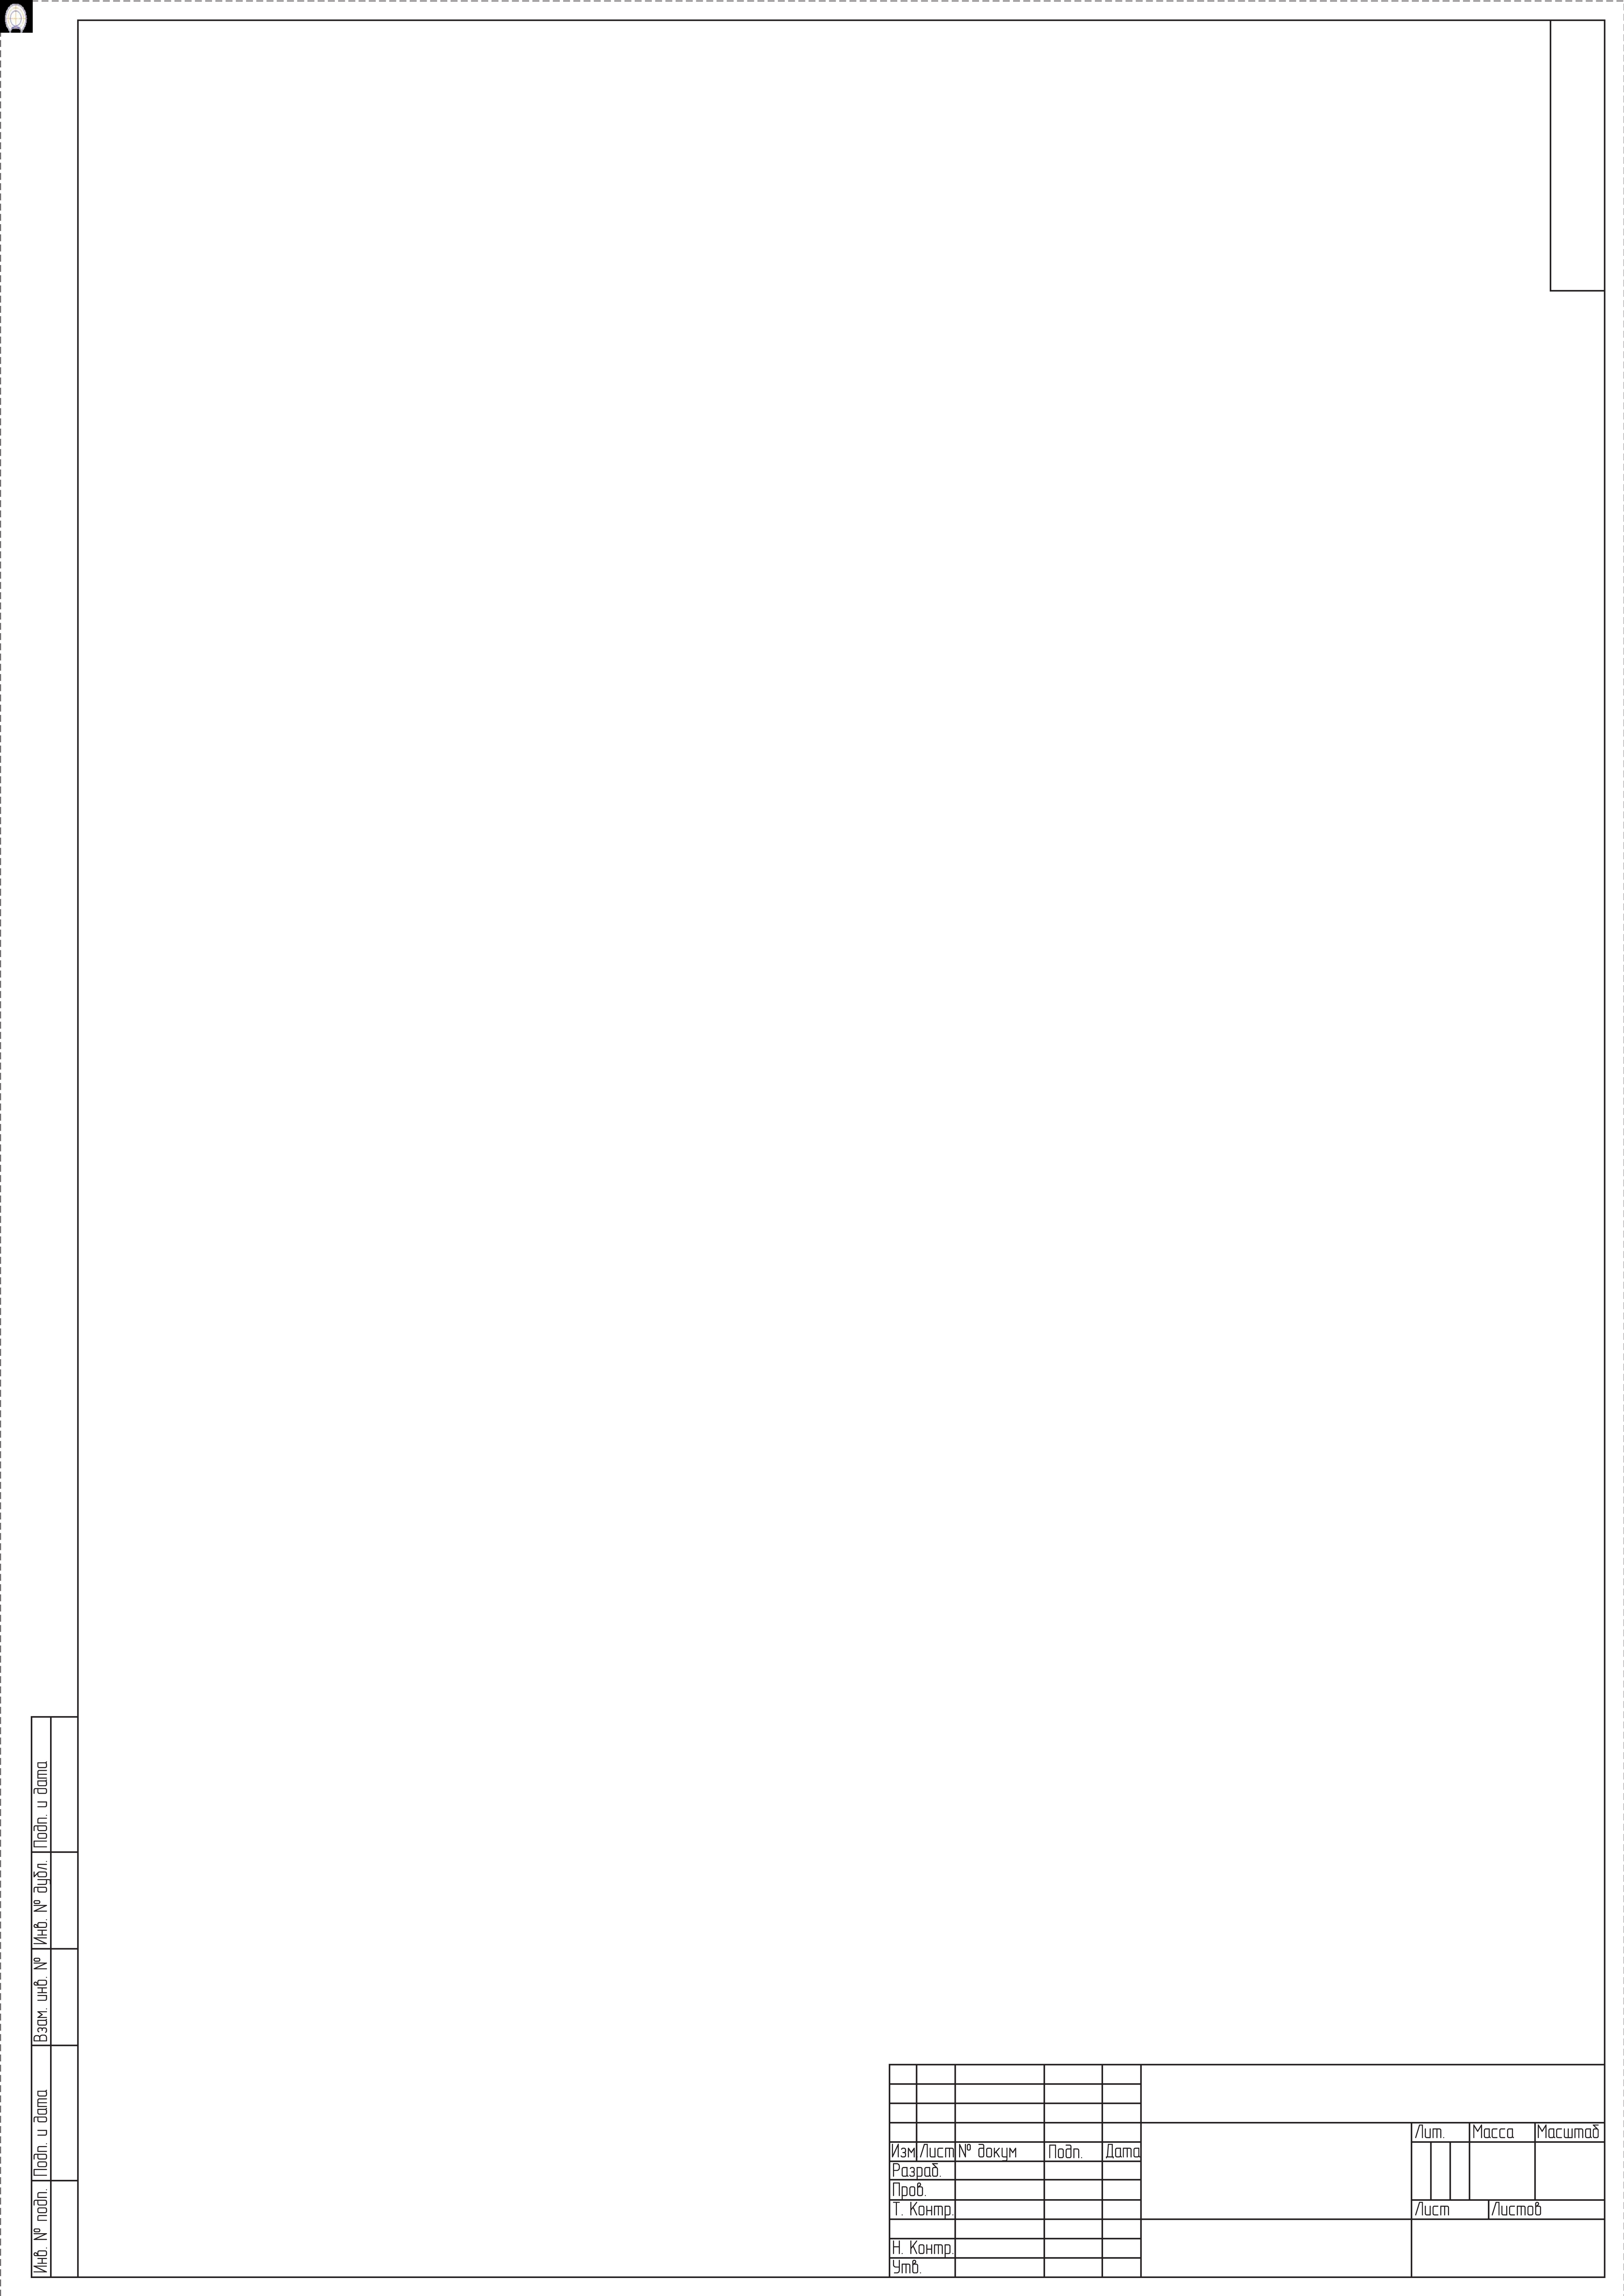

In [ ]:
dst = img1.copy()
h,w,ch = img2.shape
for i in range(h):
  for j in range(w):
    dst[i,j,:]= img2[i,j,:] if img2[i,j][0]!=0 else [255,255,255]

cv2_imshow(dst)